# Movie Classification Jupyter Notebook

## Introduction to TF-IDF

taken from: https://colab.research.google.com/drive/1OiTSBRkHB0c-2nCDRQGVsP1V5Os80Ao8?usp=sharing

**[TF-IDF](https://en.wikipedia.org/wiki/Tf–idf)** (Term Frequency-Inverse Document Frequency) is a way of measuring how relevant a word is to a document in a collection of documents.

This is done by multiplying two metrics:

*   Term Frequency (TF): how many times a word appears in a document.
*   Inverse Document Frequency (IDF): the inverse document frequency of the word across a collection of documents. Rare words have high scores, common words have low scores.

TF-IDF could be used for information retrieval, text analysis, keyword extraction, and as a way of obtaining numeric features from text for machine learning algorithms.

## Motivation for TF-IDF

TF-IDF was originally developed for document search and information retrieval. Say, you want to build a system that has to find the most relevant documents for a given input query.

Suppose you develop a tool for technical documentation. If you get a query "asynchronous update". The system would give each document a higher score proportionally to the frequencies of the query words found in the document, weighting more rare words like "asynchronous" with respect to common words like "update".

## How to compute TF-IDF?

There are several ways of calculating TF, with the simplest being a raw count of instances a word appears in a document.

> TF(word, document) = “number of occurrences of the word in the document” / “number of words in the document”

IDF can be calculated by taking the total number of documents, dividing it by the number of documents that contain a word, and calculating the logarithm. If the word is very common and appears in many documents, this number will approach 0. Otherwise, it will approach 1.

> IDF(word) = log(number of documents / number of documents that contain the word)


Notice that if if a word appears in all of the documents and thus is irrelevant word it does not contribute to the TF-IDF scores.

There are better-performing ranking functions in the information-retrieval literature. Here is another example: [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25).



## Multiclass Movie Classification with TF-IDF

In [1]:
'# mount the google drive account
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# change the path to the file with movies
!cd /content/drive/MyDrive/Semantic_Data_Processing/

In [3]:
import pandas as pd

"""
There are 27 categories of movies
"""

# read the txt file and preprocess it
df = pd.read_csv("/content/drive/MyDrive/Semantic_Data_Processing/train_data.txt", sep=":::", \
                 header=None, engine="python", names=["DELETE", "Movie", "Category", "Description"])
df = df[["Movie", "Category", "Description"]]

df_copy = df.copy()

# Let's try to take a sample for the unevenly-sampled dataset and for chi2 to work properly
df_copy = df_copy.sample(10000, random_state = 1)


# or do it with a even sampling by calculating the inverse weights for each class
df["weights"] = 1 / df.groupby("Category")["Movie"].transform("count")

# Take a sample of data first, not to "kill" the kernel
N = 10000
sample_test_size = int(round(N * 0.25, 0))
df = df.sample(N, random_state = 1)

# Take a test sample of data and delete it from the dataframe so that the same entries are not present in the test dataset
df_test = df.sample(sample_test_size, random_state = 1 )
df = df.drop(df_test.index)

# Now an evenly-sampled dataset is created with oversampling method
df = df.sample(N - sample_test_size, weights="weights", random_state = 1, replace=True) # weights are not considered

# Combine the two dataframes
df = pd.concat([df, df_test], ignore_index=True, sort=False)

df

,Movie,Category,Description,weights
0,"""Kvieciu Vakarienes"" (2011)",reality-tv,"A group of five strangers, each an amateur ch...",0.001131
1,Little League's Official How-to- Play Basebal...,family,Little League's Official How-to-Play Baseball...,0.001276
2,A Little Worm (1995),short,"In 1929, in Chicago, 12 year old Larry Adler ...",0.000197
3,"""Catch Phrase"" (1998)",game-show,The game begins with one of the contestants p...,0.005155
4,Monsieur Mayonnaise (????),history,"ADVENTURE Jewish heroes and anti-Nazis, Georg...",0.004115
...,...,...,...,...
9995,Bridge the Gap: Tanzania (2009),documentary,"Would it surprise you that ""One in three peop...",0.000076
9996,Mad About You (1989),comedy,"Casey, a vice president of her father's compa...",0.000134
9997,Apartment of Erotic Horror (2006),horror,A sleazy photographer makes a deal with a hid...,0.000454
9998,In a Dream (2008),documentary,"Over the past four decades, artist Isaiah Zag...",0.000076


<Axes: title={'center': 'NUMBER OF MOVIES IN EACH CATEGORY (original dataset)\n'}, ylabel='Category'>

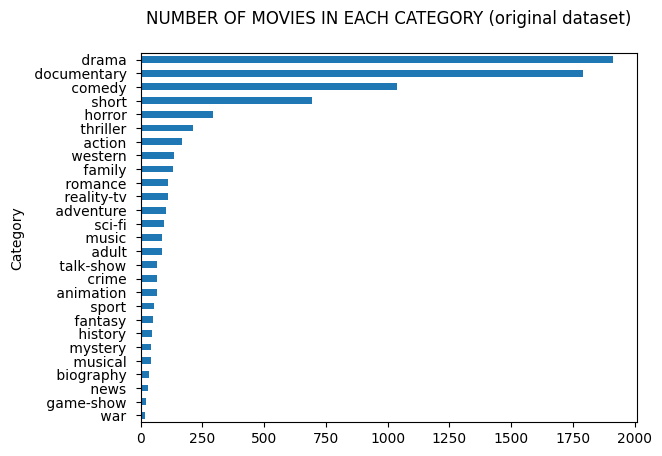

In [4]:
# displaying the number of movies in each category
df_copy[:7500].groupby("Category")["Description"].count().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF MOVIES IN EACH CATEGORY (original dataset)\n')

As the plot shows, the classes are not evenly-distributed. Therefore, it is necessary to use some sampling techniques.

<Axes: title={'center': 'NUMBER OF MOVIES IN EACH CATEGORY (with oversampling)\n'}, ylabel='Category'>

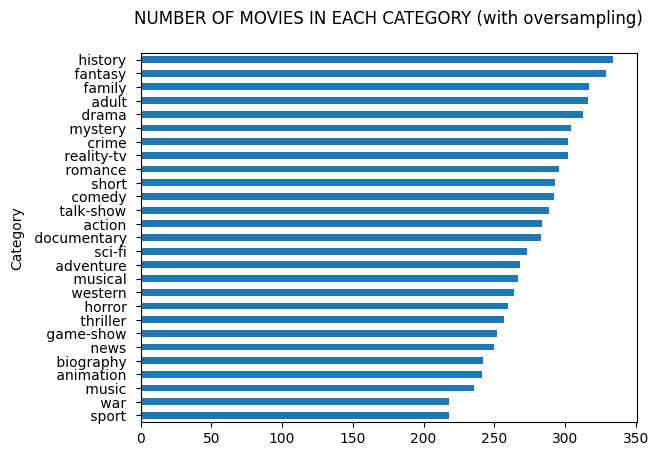

In [5]:
# displaying the number of movies in each category
df[:7500].groupby("Category")["Description"].count().sort_values().plot.barh(
    ylim=0, title= 'NUMBER OF MOVIES IN EACH CATEGORY (with oversampling)\n')

Encoding the categories

In [6]:
# Create a new column 'category_id' with encoded categories
df['category_id'] = df['Category'].factorize()[0]
category_id_df = df[['Category', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Category']].values)

category_to_id

{' reality-tv ': 0,
 ' family ': 1,
 ' short ': 2,
 ' game-show ': 3,
 ' history ': 4,
 ' news ': 5,
 ' crime ': 6,
 ' drama ': 7,
 ' sci-fi ': 8,
 ' romance ': 9,
 ' comedy ': 10,
 ' action ': 11,
 ' animation ': 12,
 ' music ': 13,
 ' musical ': 14,
 ' documentary ': 15,
 ' sport ': 16,
 ' fantasy ': 17,
 ' war ': 18,
 ' thriller ': 19,
 ' talk-show ': 20,
 ' western ': 21,
 ' mystery ': 22,
 ' horror ': 23,
 ' adult ': 24,
 ' adventure ': 25,
 ' biography ': 26}

Using TF-IDF Vectorizer for the oversampled dataset

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df["Description"]).toarray()

labels = df.category_id

print("Each of the %d movies is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 movies is represented by 38476 features (TF-IDF score of unigrams and bigrams)


Finding the three most correlated terms with each of the product categories using chi2 from sklearn.

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np


N = 3
for Description, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n---> %s:" %(Description))
  print("    Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("    Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


--->  action :
    Most Correlated Unigrams are: vijay, sunil, ravi
    Most Correlated Bigrams are: hired kill, jack quick, employees kidnapped

--->  adult :
    Most Correlated Unigrams are: sex, bound, gagged
    Most Correlated Bigrams are: second story, horny men, bound gagged

--->  adventure :
    Most Correlated Unigrams are: cleo, tanks, jungle
    Most Correlated Bigrams are: sam max, plot steal, desert island

--->  animation :
    Most Correlated Unigrams are: irrational, ene, shintaro
    Most Correlated Bigrams are: mighty raju, buttons rusty, george paul

--->  biography :
    Most Correlated Unigrams are: tattooing, hughie, norma
    Most Correlated Bigrams are: paul vi, chae sun, norma jean

--->  comedy :
    Most Correlated Unigrams are: si, hilarious, comedy
    Most Correlated Bigrams are: opposite sex, comedy takes, comedy series

--->  crime :
    Most Correlated Unigrams are: lanz, risi, investigations
    Most Correlated Bigrams are: targets turns, figure you

# Classification

In [8]:
# Importing the libraries necessary for the classification task
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

Let us train several models, namely,

*   Random Forest
*   Linear Support Vector Machine
*   Multinomial Naive Bayes
*   Logistic Regression

In [9]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=1),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [ ]:
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV, verbose=1)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])


In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.7902,0.086328
LogisticRegression,0.7456,0.087453
MultinomialNB,0.5419,0.059071
RandomForestClassifier,0.1702,0.004725


Doing the same for unevenly-distributed dataset

In [34]:
tfidf_uneven = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features_uneven = tfidf_uneven.fit_transform(df_copy["Description"]).toarray()

df_copy['category_id'] = df_copy['Category'].factorize()[0]
labels_uneven = df_copy.category_id

print("Each of the %d movies is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 movies is represented by 38476 features (TF-IDF score of unigrams and bigrams)


In [ ]:
entries_uneven = []
for model in models:
  model_name = model.__class__.__name__
  accuracies_uneven = cross_val_score(model, features_uneven, labels_uneven, scoring='accuracy', cv=CV, verbose=1)
  for fold_idx, accuracy in enumerate(accuracies_uneven):
    entries_uneven.append((model_name, fold_idx, accuracy))

In [15]:
cv_df_uneven = pd.DataFrame(entries_uneven, columns=['model_name', 'fold_idx', 'accuracy'])

In [16]:
mean_accuracy_uneven = cv_df_uneven.groupby('model_name').accuracy.mean()
std_accuracy_uneven = cv_df_uneven.groupby('model_name').accuracy.std()

acc_uneven = pd.concat([mean_accuracy_uneven, std_accuracy_uneven], axis= 1,
          ignore_index=True)
acc_uneven.columns = ['Mean Accuracy', 'Standard deviation']
acc_uneven

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.5466,0.009711
LogisticRegression,0.5206,0.010121
MultinomialNB,0.4537,0.008892
RandomForestClassifier,0.4111,0.004084


CONCLUSION:
- LinearSVC gives the best accuracy - around 54,7% with simple sampling
- LinearSVC and LogisticRegression gives the best accuracy for oversampled data - 79% and 74,6% respectively.

Note: with oversampling, the accuracies from the previous cell may not be accurate, because there are many equal entries in the dataset. Therefore, it is necessary to train a specific algorithm to check the actual accuracy on test ("unseen") data.

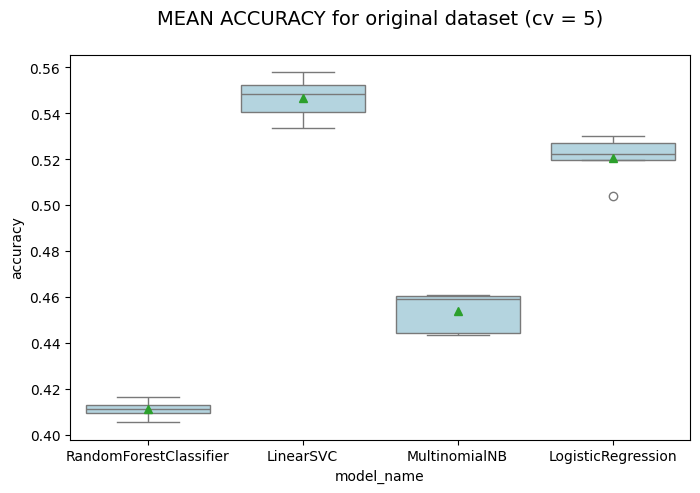

In [20]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df_uneven,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY for original dataset (cv = 5)\n", size=14);

## Evaluation

Over-sampling method:

In [41]:
# for over-sampling
divider = N - sample_test_size
X_train = features[:divider]
X_test = features[divider:]
y_train = labels[:divider]
y_test = labels[divider:]


#model = LinearSVC()
model = LinearSVC(random_state=1) #better for evenly-sampled data
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [26]:
# Classification report for over-sampling
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test, y_pred,
                                    target_names= df_test['Category'].unique()))

				CLASSIFICATIION METRICS

               precision    recall  f1-score   support

    thriller        0.16      0.45      0.24        33
       drama        0.19      0.29      0.23        42
 documentary        0.30      0.30      0.30       249
      sci-fi        0.86      0.75      0.80         8
      action        0.00      0.00      0.00        17
      comedy        0.00      0.00      0.00        13
       short        0.06      0.05      0.05        21
     western        0.55      0.42      0.47       623
      horror        0.35      0.34      0.35        41
       crime        0.18      0.35      0.24        34
       music        0.42      0.35      0.38       364
       sport        0.20      0.34      0.25        53
  reality-tv        0.20      0.12      0.15        17
   adventure        0.29      0.63      0.40        30
     musical        1.00      0.08      0.14        13
      family        0.68      0.64      0.66       592
     romance        0.62      0.38 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Original dataset:

In [21]:
X_train_uneven, X_test_uneven, y_train_uneven, y_test_uneven ,indices_train_uneven,indices_test_uneven = train_test_split(features_uneven,
                                                                                                                          labels_uneven,
                                                                                                                          df_copy.index, test_size=0.25,
                                                                                                                          random_state=1)

In [22]:
model_uneven = LinearSVC(random_state=1) #better for evenly-sampled data
model_uneven.fit(X_train_uneven, y_train_uneven)
y_pred_uneven = model_uneven.predict(X_test_uneven)

In [23]:
# Classification report for original dataset
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(y_test_uneven, y_pred_uneven,
                                    target_names= df_test['Category'].unique()))

				CLASSIFICATIION METRICS

               precision    recall  f1-score   support

    thriller        0.63      0.84      0.72       592
       drama        0.38      0.24      0.30       249
 documentary        0.22      0.09      0.13        22
      sci-fi        0.52      0.72      0.60       623
      action        0.50      0.54      0.52       364
      comedy        0.26      0.14      0.18        57
       short        0.50      0.10      0.16        42
     western        0.55      0.18      0.27        33
      horror        0.69      0.33      0.45        27
       crime        0.37      0.21      0.27        53
       music        0.60      0.52      0.56       105
       sport        0.00      0.00      0.00         9
  reality-tv        0.50      0.03      0.06        34
   adventure        0.69      0.30      0.42        30
     musical        0.00      0.00      0.00        17
      family        1.00      0.68      0.81        57
     romance        0.00      0.00 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In conclusion, over-sampling method does not increase the accuracy of the model (45% with over-sampling and 55% with the original dataset). However, the increase is due to more entries for bigger classes, such as: thriller, sci-fi, action, etc.

## Confusion Matrix

for over-sampling method

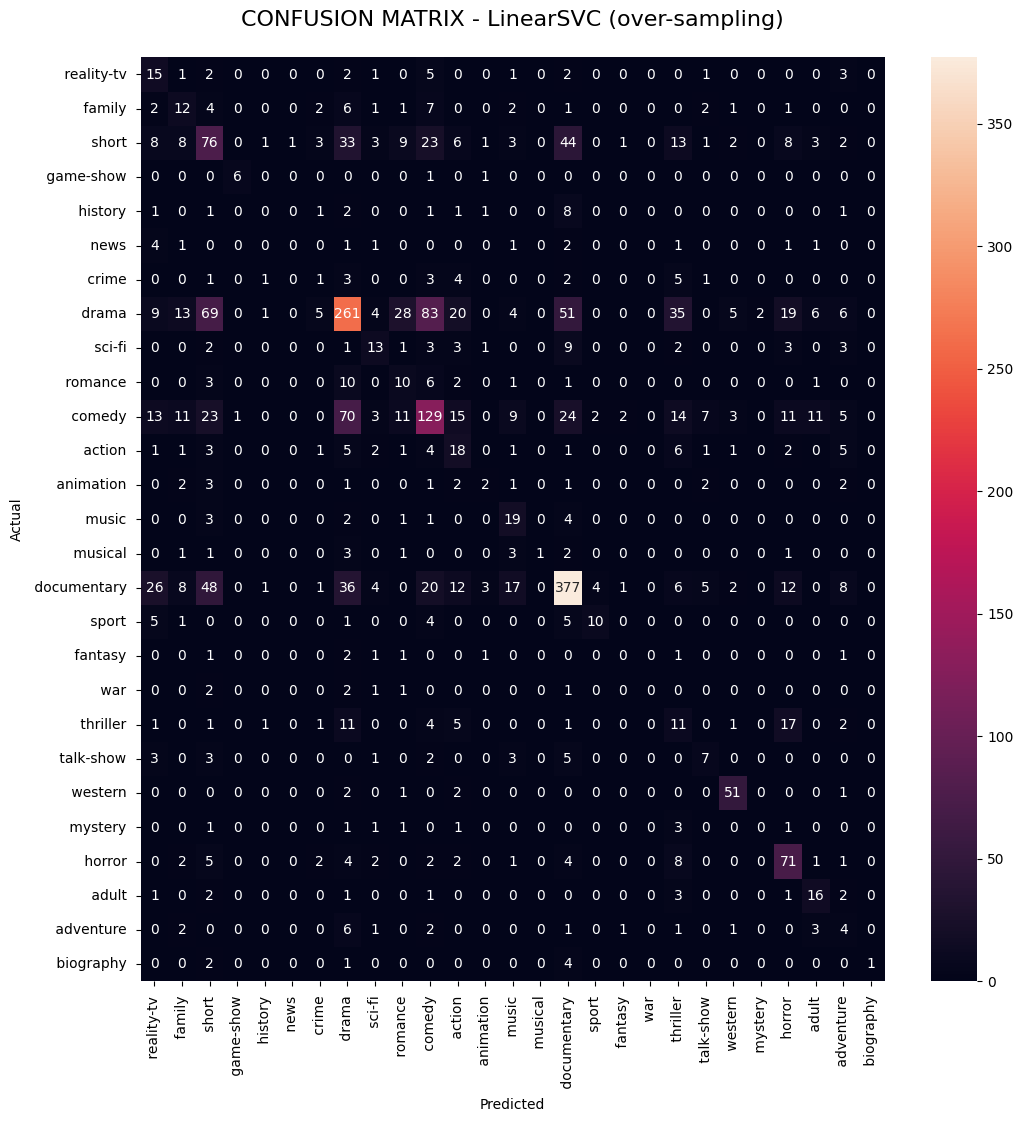

In [45]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat, annot=True,  fmt='d',
            xticklabels=category_id_df.Category.values,
            yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC (over-sampling)\n", size=16);

for the original dataset

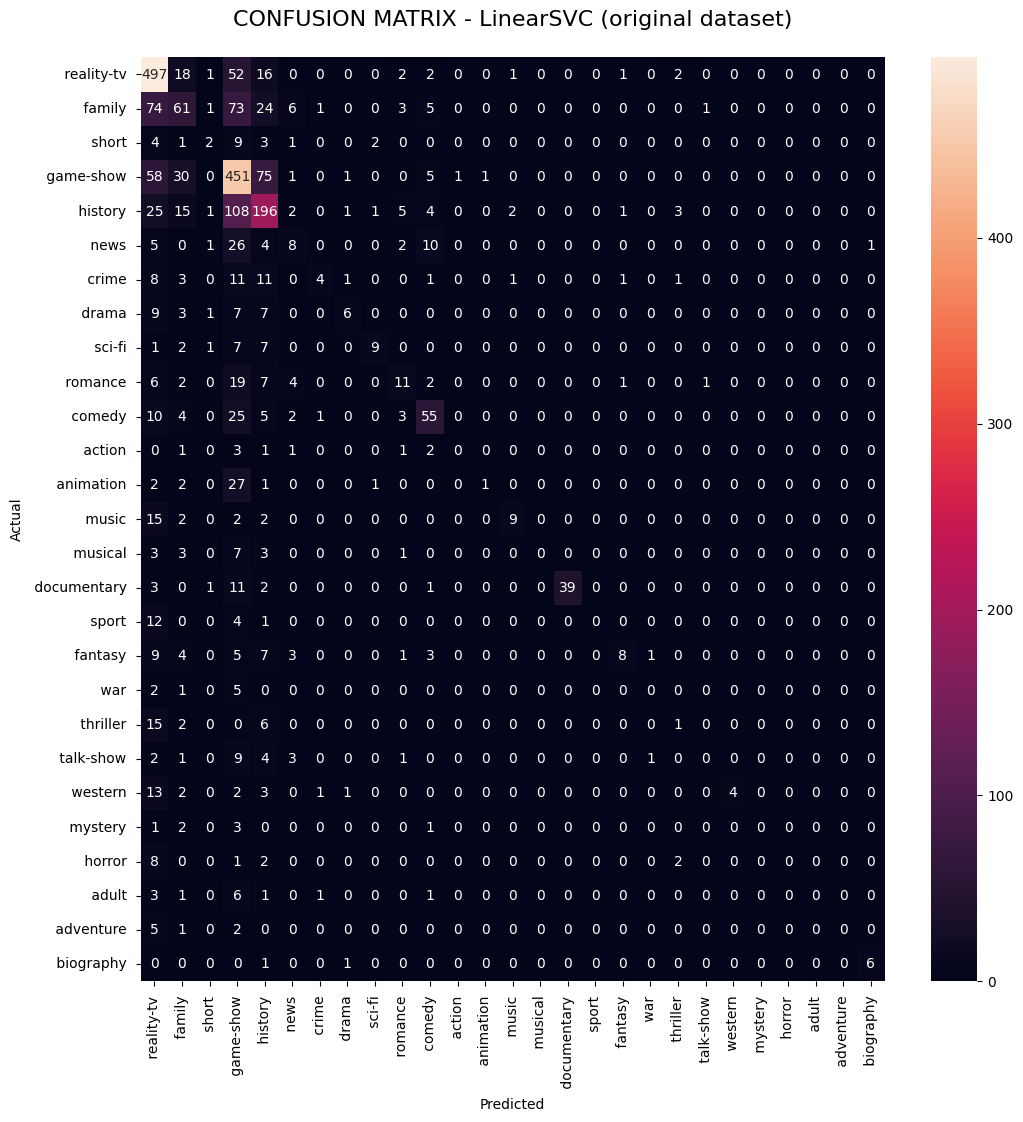

In [44]:
conf_mat_uneven = confusion_matrix(y_test_uneven, y_pred_uneven)
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(conf_mat_uneven, annot=True,  fmt='d',
            xticklabels=category_id_df.Category.values,
            yticklabels=category_id_df.Category.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC (original dataset)\n", size=16);

# Analysing Results

for the original dataset (no over-sampling)

In [31]:
for predicted in category_id_df.category_id:
  for actual in category_id_df.category_id:
    if predicted != actual and conf_mat_uneven[actual, predicted] >= 20:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual],
                                                           id_to_category[predicted],
                                                           conf_mat_uneven[actual, predicted]))

      display(df_copy.loc[indices_test_uneven[(y_test_uneven == actual) & (y_pred_uneven == predicted)]][['Category',
                                                                'Description']])
      print('')

' family ' predicted as ' reality-tv ' : 74 examples.


,Category,Description
14522,short,Khush means ecstatic pleasure in Urdu. For So...
39682,short,the film is talking about a person who is mak...
51680,short,"""This active little animal has made a great h..."
25735,short,"We live in a hectic worked, where everyone ju..."
48496,short,"On the march for progress, mankind kept wasti..."
...,...,...
49239,short,Steve McQueen multiply remakes the most famou...
14451,short,A mockumentary showcasing terrorism paranoia ...
5776,short,Water is more than just a simple mixture of h...
53154,short,"A long, long night has come. It will continue..."



' game-show ' predicted as ' reality-tv ' : 58 examples.


,Category,Description
36971,drama,"1888: a luthier, Vedder (Gijs Scholten van As..."
24244,drama,Deceptively simple and with unsettling intell...
37088,drama,"For the children of Northern Ireland, violenc..."
18210,drama,"The inspiring true story of ""Brundibar,"" an o..."
27882,drama,"Devenir, a movie made with less than $6000 Do..."
24585,drama,"In the aftermath of the 1967 defeat, four you..."
10886,drama,"In 1930's Shanghai, Wu Sunpu, chief executive..."
30024,drama,"Olga, Katya, and Andrey have known each other..."
4274,drama,The industries are shutting down and jobs are...
11894,drama,Donde cae el sol tells a little story between...



' history ' predicted as ' reality-tv ' : 25 examples.


,Category,Description
29097,comedy,"Filmed in the O.C., the show features explosi..."
26375,comedy,Extreme hidden camera comedy at its finest. S...
23147,comedy,"""My Hair Song"" is a song where comedic duo Rh..."
48235,comedy,Charles Dickens' classic heart warming tale.....
52992,comedy,On the morning of 31st December at a Belgrade...
46220,comedy,Robin Turner is a gay hairdresser. He hates h...
51874,comedy,"The film narrates a utopian abandonment, cons..."
44299,comedy,Best-selling author and noted history profess...
33200,comedy,As Brasileiras (The Brazilian Women) is a Bra...
2862,comedy,Snakeville is the story of a neglected town h...



' game-show ' predicted as ' family ' : 30 examples.


,Category,Description
18947,drama,'The Life of Insects' will be a dark comedy b...
45327,drama,The security guard Luther Bentley begins hear...
24545,drama,Unfulfilled housewife Allison (Darian Caine) ...
2510,drama,The film offers a glimpse at a group of schoo...
45468,drama,"""Flourishing Life"" is a story of a young man,..."
311,drama,"Moving Picture World, 19 August 1922. John Ca..."
34153,drama,A woman's pain takes her on a dark journey wh...
16980,drama,"A mechanical man, within an elaborate shootin..."
28340,drama,Drama runs deep with betrayal between friends...
48283,drama,In Winter is an independent feature emerging ...



' reality-tv ' predicted as ' game-show ' : 52 examples.


,Category,Description
27319,documentary,'Lucky Me' is a documentary profiling the lif...
36390,documentary,"Ralph Nieves, a charismatic Latino former und..."
38346,documentary,This is an extraordinary tale of an amazing f...
24929,documentary,What makes a jet setting 'power-blonde' busin...
15500,documentary,Spanning the globe in search of living stigma...
16768,documentary,Two vastly different men in vastly different ...
20435,documentary,Approximately 2000 summer cinemas have existe...
2072,documentary,"Equipped with seven draft picks, follow the M..."
5171,documentary,Alessandro Gualtieri is an independent rebel ...
12323,documentary,Passing time fills a central role in Baderech...



' family ' predicted as ' game-show ' : 73 examples.


,Category,Description
47161,short,An emotional story of a husband that is rarel...
4216,short,A young woman escapes her habitual tasks thro...
3946,short,Three young desperados are chasing a colony o...
14097,short,None flowers in the garden can not be compare...
29746,short,What happens when a female Polish capitalist ...
...,...,...
46114,short,Twelve-year old Maggie likes to build miniatu...
13784,short,"When Noelle was one, her mother abandoned her..."
12936,short,Escaping from a boring and oppressive adult w...
52575,short,"""Wintergartenprogramm"" is a collection of sni..."



' history ' predicted as ' game-show ' : 108 examples.


,Category,Description
1197,comedy,"Soriano brothers Dennis, Chipipoy/Chip, and J..."
38041,comedy,A divorced director and his theatre company d...
20197,comedy,When Lambodar Bhatt is given the opportunity ...
41281,comedy,Bobby Ray Summers is a 30-year-old unmarried ...
29467,comedy,Scatterbrained Sally Elliott tries to get a j...
...,...,...
34913,comedy,Larry (Jason Schwartzman) is content with his...
14713,comedy,Walter Duts lives a quite existence in a rura...
40207,comedy,In order to avenge his insult against wealthy...
3739,comedy,"Lonnie, Dominic and 'G' are three bachelor bu..."



' news ' predicted as ' game-show ' : 26 examples.


,Category,Description
40884,thriller,Michael Barrymore's life changes dramatically...
16882,thriller,Former prom queen Joy is now an agoraphobic h...
33694,thriller,"After a near-death experience overseas, war c..."
43537,thriller,Weil er brutalen Dealern das Handwerk legen w...
45512,thriller,"""In the life of every person there are inflec..."
52955,thriller,Sensitive wallflower Cara exists in her humdr...
34680,thriller,"A trio of naive, but eager young Midwestern w..."
18140,thriller,"Carmen a widower has two daughters, Anna and ..."
13101,thriller,Chehere is a period drama set in the 1950s th...
20499,thriller,After losing his family in a car accident and...



' comedy ' predicted as ' game-show ' : 25 examples.


,Category,Description
48719,horror,Steve is a successful businessman in Dallas. ...
46559,horror,A young women (Julie Summers) must return to ...
43090,horror,When your character received the message that...
21922,horror,Six friends go out to the middle of nowhere o...
33328,horror,An independent film company sends a videograp...
4241,horror,EVERETT TURNER is a Santa Barbara police offi...
4620,horror,One man's struggle to contain the curse he hi...
29837,horror,Claire Brennen stars as a waitress who leaves...
24036,horror,The Candyman moves on to New Orleans and star...
39505,horror,A SAVANNAH HAUNTING is a supernatural thrille...



' animation ' predicted as ' game-show ' : 27 examples.


,Category,Description
34031,romance,"A couple meet, after a separation - perhaps f..."
30993,romance,When Fleur arrives on her brother Hugo's door...
34028,romance,Mann Kapoor lives a middle-class lifestyle in...
38852,romance,Jaanu is a rich 19-year-old girl has a family...
50207,romance,A radio-reporter watches a window-washer and ...
3281,romance,"This is the story of Venu, a middle class you..."
377,romance,Provincial singer Andrei dreams of fame. When...
52971,romance,This is a web series with different segments ...
18709,romance,A Euro tunnel love affair as mild manner Engl...
46689,romance,Times change - the characters change. But how...



' family ' predicted as ' history ' : 24 examples.


,Category,Description
15126,short,Emily and Aidan have a chance meeting at a ba...
39608,short,A determined young artist will do anything to...
53513,short,"Frank, an awkward slouchy man, daydreams abou..."
19236,short,A grandmother talks about the love affairs of...
3850,short,"Florin a thirty something, is coming back fro..."
32104,short,"Evelyne's lover has just broken up with her, ..."
1068,short,A romantic comedy about a high school bully w...
10669,short,"""Slice of Pie"" is a romantic comedy with an u..."
178,short,The story surrounds the boyfriend; having met...
23121,short,Todd always does his best to go above and bey...



' game-show ' predicted as ' history ' : 75 examples.


,Category,Description
19938,drama,"""Here is to friends."" As Terry, Jensen and Wi..."
41741,drama,"An 11-year-old street boy, Obdulio, who sells..."
38283,drama,A beautiful and ambitious young woman leaves ...
35020,drama,Sgt. Kevin Hill is a 22 year-old US Army Rang...
3634,drama,"Ruby and Garnet are identical twins, ten year..."
...,...,...
39382,drama,Oridam is a quest of a sex worker to find a p...
31002,drama,Jason is an advertising executive whose life ...
17071,drama,On the last day of school to celebrate gradua...
53856,drama,A woman is desperate to find real love in a s...


Analysing and printing the top unigrams and bigrams for each movie category based on the coefficients of the features in TF-IDF Vectorizer model.

In [40]:
import numpy as np

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model_uneven.coef_[category_id])
  feature_names = np.array(tfidf_uneven.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> ' action ':
  * Top unigrams: solve, detective, dead, naomi
  * Top bigrams: mysterious murders, soon turns, 100 000, loving husband

==> ' adult ':
  * Top unigrams: musical, broadway, juliet, zhao
  * Top bigrams: romeo juliet, feature film, make big, small rural

==> ' adventure ':
  * Top unigrams: pope, berlin, nazi, service
  * Top bigrams: high society, half century, young people, little italy

==> ' animation ':
  * Top unigrams: love, priya, hyun, mi
  * Top bigrams: day meets, lead singer, life love, beautiful young

==> ' biography ':
  * Top unigrams: contestants, correct, contestant, teams
  * Top bigrams: prize money, friday night, final round, features new

==> ' comedy ':
  * Top unigrams: horror, vampire, evil, halloween
  * Top bigrams: fall victim, group teenagers, horror film, murderous rampage

==> ' crime ':
  * Top unigrams: kids, preschool, children, fun
  * Top bigrams: long remember, children ages, financial crisis, love family

==> ' documentary ':
  * T

Coming up with a new movie description from internet to check if the model is able is able to predict the genre correctly. LinearSVC model is used with no over-sampled dataset:

In [39]:
# this is Titanic movie, which is drama or romance according to IMDB
new_movie = """84 years later, a 100 year-old woman named Rose DeWitt Bukater tells the story to her granddaughter Lizzy Calvert, Brock Lovett, Lewis Bodine, Bobby Buell and Anatoly Mikailavich on the Keldysh about her life set in April 10th 1912, on a ship called Titanic when young Rose boards the departing ship with the upper-class passengers and her mother, Ruth DeWitt Bukater, and her fiancé, Caledon Hockley. Meanwhile, a drifter and artist named Jack Dawson and his best friend Fabrizio De Rossi win third-class tickets to the ship in a game. And she explains the whole story from departure until the death of Titanic on its first and last voyage April 15th, 1912 at 2:20 in the morning. """
print(id_to_category[model_uneven.predict(tfidf_uneven.transform([new_movie]))[0]])

 game-show 


In [38]:
# movie: All Quiet on the Western Front. It should be war, action, drama, according to IMDB
new_movie = """The story follows teenagers Paul Bäumer and his friends Albert and Müller, who voluntarily enlist in the German army, riding a wave of patriotic fervor that quickly dissipates once they face the brutal realities of life on the front. Paul's preconceptions about the enemy and the rights and wrongs of the conflict soon crumble. However, amid the countdown to armistice, Paul must carry on fighting until the end, with no purpose other than to satisfy the top brass' desire to end the war on a German offensive."""
print(id_to_category[model_uneven.predict(tfidf_uneven.transform([new_movie]))[0]])

 history 


The guess for movie Titanic was wrong. Nevertheless, movie All Quiet on the Western Front is based on history and it makes sense that the model predicted it as history. On IMDB website, the category "history" is not mentioned for this movie.